# Amarração de poço antigo na Bacia do Parnaíba utilizando perfil de resistividade


Utilizamos o poço 2-BGST-1-MA e a linha X da Bacia do Parnaíba. Corrigimos com o checkshot extraído do poço 1-FL-1-PI.

In [193]:
import numpy as np
from matplotlib import pylab
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from obspy.io.segy.segy import _read_segy
from scipy.signal import hilbert
%matplotlib inline

In [151]:
cd "G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\2-BGST-1-MA"

G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\2-BGST-1-MA


In [152]:
data = np.loadtxt('Dados_amarrando.csv', delimiter=';')

**(0)Profundidade_DM (1)Resistividade (2)Fator_Formação (3)Vagarosidade/Sônico (4)Densidade (5)Impedância**

In [153]:
#CARREGANDO OS DADOS
profundidade = data[:,0]
resistividade = data[:,1]
velocidade = 1./data[:, 3]
impedancia = data[:,5]

## Funções

#### Função para criar o vetor tempo duplo a partir dos dados de profundidade e velocidade

In [154]:
def transf_prof_tempo(profundidade, velocidade):
    """
    Retorna um array de tempo, a partir dos arrays de
    profundidades e velocidades (Sônico) dos dados de poço
    
    *profundidade : array
        Dados de poço de profundidade
    *velocidade : array
        Dados do perfil sônico do poço (1/vagarosidades) - em km
    *tempo : array
        Retorna o tempo calculado
    
    """
    
    #Transformando Profundidade em Tempo
    dx=(profundidade[1:] - profundidade[:-1])
    dt=(dx*0.001)/velocidade[:-1]
    
    #VETOR TEMPO
    tempo = np.zeros(dt.size+1)
    
    tempo[0] = 0
    soma = dt[0]
    for i in range(1, dt.size+1):
        soma += dt[i-1]
        tempo[i] = soma
    tempo*=2
    
    return tempo

#### !!!Função para encontrar um *tempo específico* dada uma *profundidade específica*!!!

Primeiramente, esta função **compara o valor fornecido de profundidade (md_depth) com cada valor do array original de profundidades**. Se algum destes for **igual** ao de profundidade (md_depth), a função **retorna o valor do array original de tempo** que estiver localizado **na mesma posição** em que está o **valor de profundidade, no array de profundidade**. (assumindo que estes têm o **mesmo tamanho**)

**Se não** for encontrado valor exatamente igual, esta função utiliza duas comparações simultâneas para encontrar **um valor logo abaixo e um logo acima** ao valor fornecido de profundidade (md_depth):
+ Compara o valor fornecido de profundidade (md_depth) **com** cada um dos valores do array de profundidade
+ Compara a diferença entre valor fornecido de profundidade (md_depth) e cada um dos valores de profundidade **com** a diferença de cada dois valores de profundidade entre si (no caso, 0.2).

Após esta comparação, a função calcula uma **regressão linear** entre os pontos logo acima e logo abaixo do valor fornecido de profundidade (md_depth), para encontrar o valor de tempo referente.

In [156]:
def depth_time(md_depth, time, depth):
    """
    Retorna o valor em TWT correspondente a md_depth a partir da
    relação tempo profundidade definida por :
    
    * md_depth : float
        profundidade que se deseja descobrir tempo referente
    * tempo : array
        dados de tempo em segundos (TWT - Two Way Time)
    * profundidade : array
        dados de profundidade metros (MD - Mesured Depth) - mesmo tamanho do tempo
    * twt_time : float
        tempo que será retornado (referente à profundidade de entrada)
        
    """
    
    for i in range(len(depth)):
        if md_depth == depth[i]:
            return time[i]            
        else: # Encontrando x1, x2, y1, y2
            if md_depth > depth[i] and md_depth - depth[i] < np.diff(depth)[i]:
                x1=depth[i]
                y1=time[i]
            if md_depth < depth[i] and abs(md_depth - depth[i]) < np.diff(depth)[i]:
                x2=depth[i]
                y2=time[i]
    
    #Calculando coeficientes
    x0 = md_depth
    a = (y2 - y1)/(x2 - x1)
    b = y1 - a*x1
    y0 = a*x0 + b
    twt_time = y0
    
    return twt_time

#### Função de Reamostragem

In [157]:
def reamostra(taxa, x, y):
    """
    Interpola e reamostra um array para uma taxa de amostragem específica.
    
    *taxa : float
        taxa de amostragem final
    *x : array
        "eixo x" da reamostragem
    *y : array
        "eixo y" da reamostragem (impedância)
    *resultado : array
        dado reamostrado e interpolado final
    
    """
    maxt = np.max(x)
    
    t = np.arange(0, maxt, taxa)
    resultado = np.interp(x = t, xp = x, fp = y)
    
    return t, resultado

#### Função de Filtragem
Evita o falseamento dos dados (alias)

In [158]:
def filtro(N, fcorte, taxa, data):
    """
    Filtra um array
    
    *N : integer
        ordem do filtro
    *fcorte : float (?)
        frequência de corte desejada
    *taxa : float
        taxa de amostragem do dado
    *data : array
        dados a serem filtrados
    *result: array
        output da função. Dados filtrados
    
    """
    
    Wn = fcorte/(1/(2*taxa)) # Cutoff frequency: Wn*Fnyquist=fcorte
    B, A = butter(N, Wn, output='ba') #Filtro Butterworth
    result=filtfilt(B,A,data)
    
    return result

#### Função para plotar a evolução desde a Resistividade até o Sintético

In [160]:
def plot_synth(resistividade, tempo, Z_fr, RC_fr, tfr, synth):
    """
    Cria um plot conjugado da evolução dos cálculos saindo da Resistividade, passando pela
    Impedância, Refletividade e chegando no Traço Sintético. Ao final, salva a imagem com o nome "plot_cria_synth"
    
    *impedância : array
        dados de impedância original do poço
    *tempo : array
        tempo calculado a partir dos arrays de profundidades e velocidades (Sônico) dos dados do poço alvo
    *Z_fr : array
        impedância filtrada e reamostrada para 4ms
    *RC_fr : array
        refletividade filtrada e reamostrada para 4ms
    *synth : array
        sintético criado a partir da convolução da refletividade com a Waveler Ricker
    *tfr : array
        tempo filtrado e reamostrado para 4ms
        
    """
    
    plt.figure(figsize=(15,15))
    
    ax1 = plt.subplot(141)
    plt.plot(resistividade, tempo, c='k', lw=1)
    plt.title('Resistvidade (ohm-m) \n', fontsize=20)
    plt.setp(ax1.get_yticklabels(), fontsize=20)
    plt.setp(ax1.get_xticklabels(), fontsize=20)
    plt.xlabel(' \n\n (a)', fontsize=20)
    plt.ylabel('Tempo (s) \n', fontsize=23)
    plt.gca().invert_yaxis()

    ax2 = plt.subplot(142)
    plt.plot(Z_fr, tfr, c='k', lw=1)
    plt.title('Impedância \n', fontsize=20)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), fontsize=20)
    plt.xlabel(' \n\n (b)', fontsize=20)
    plt.gca().invert_yaxis()
    
    ax3 = plt.subplot(143)
    plt.hlines(tfr[:-1], 0, RC_fr, lw=1) #refletividade em barrinhas
    plt.plot([0, 0], [tfr.min(), tfr.max()], c='k', alpha = 1, lw=1) #middle bar
    plt.title('Refletividade \n', fontsize=20)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), fontsize=20)
    plt.xlabel(' \n\n (c)', fontsize=20)
    plt.gca().invert_yaxis()
    
    ax4 = plt.subplot(144)
    plt.plot(synth, tfr[:-1], c='k')
    plt.title('Traço Sintético \n', fontsize=20)
    plt.setp(ax4.get_yticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), fontsize=20)
    plt.xlabel(' \n\n (d)', fontsize=20)
    plt.gca().invert_yaxis()
    
    plt.savefig('plot_cria_synth', dpi=600)

#### Funções para criar a Ricker e convolvê-la com a Refletividade

In [162]:
def ricker(f, length, dt):
    """
    Criação da Wavelet Ricker
    *f : float
        frequência central
    *length : float
        tamanho da ricker
    *dt : float
        taxa de amostragem
    
    """
    t = np.linspace(-length / 2, (length-dt) / 2, length / dt)
    y = (1. - 2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

In [163]:
def convolucao(RC_fr):
    """
    Convolução da Refletividade com a Wavelet Ricker
    
    *RC_fr : array
        refletividade filtrada e reamostrada para 4ms
    *f : float
        frequência central
    
    """
    
    RC_fr = np.nan_to_num(RC_fr)
    tw, w = ricker (f=25, length = 0.256, dt = 0.004)
    synth = np.convolve(w, RC_fr, mode='same')
    
    return synth

#### Função para criar e plotar o sintético

Faz a reamostragem da Impedância, calcula a Refletividade, convolve a Refletividade com a Wavelet Ricker e faz os plots de: controle de qualidade da reamostragem e da evolução Resistividade -> Impedância -> Refletividade -> Traço Sintético. 

In [185]:
def cria_synth(resistividade, impedancia, tempo, N, fcorte, taxa_r, pol=True, plot=True):
    """
    Reamostra e filtra (passa baixa) um perfil de impedância para a taxa desejada. Retorna a
    refletividade reamostrada junto com o plot conjugado desde o dado original até o dado reamostrado e filtrado.
    O plot retornado funciona como controle de qualidade. Se não desejar plotar, troque o parâmetro para "False".
    
    *impedância : array
        dados de impedância original do poço
    *tempo : array
        tempo calculado a partir dos arrays de profundidades e velocidades (Sônico) dos dados do poço  alvo
    *N : integer
        ordem do filtro
    *fcorte : integer
        frequência de corte para o filtro passa baixa
    *taxa : float
        taxa de amostragem desejada. Recomenda-se que seja a mesma taxa de amostragem do dado sísmico
    *pol : opcional
        Polaridade do dado sísmico. Assume-se polaridade positiva. Se o dado estiver com polaridade SEG positiva, não mudar.
        Se a polaridade estiver invertida, trocar esta variável para False.
    *plot : opcional
        plot = False - não plota os gráficos    
    
    *VARIÁVEIS LOCAIS DA FUNÇÃO:
    
    *Z_t*: *i**mpedância *r*eamostrada para uma taxa menor que a variação mínima da impedância original  
    *Z_f*: *i**mpedância *f*iltrada com filtro passa-baixa  
    *Z_fr*: *i**mpedância *f*iltrada e *r*eamostrada para 4ms  
    *RC*: *r**efletividade calculada a partir dos dados de impedância original do poço  
    *RC_t*: *r**efletividade *r*eamostrada para uma taxa menor que a variação mínima da impedância original  
    *RC_f*: *r**efletividade *f*iltrada com filtro passa-baixa  
    *RC_fr*: *r**efletividade *f*iltrada e *r*eamostrada para 4ms  
    *t*: *t*empo *r*eamostrado para uma taxa menor que a variação mínima da impedância original  
    *tfr*: *t*empo *f*iltrado e *r*eamostrado para 4ms

    """
    
    #-------------------REAMOSTRANDO O TEMPO (com a menor variação de tempo)----------------------#
    
    taxa = np.min(np.diff(tempo)) #variação mínima do tempo original
    (t, Z_t) = reamostra(taxa, tempo, impedancia)
    RC_t = (Z_t[1:] - Z_t[:-1]) / (Z_t[1:] + Z_t[:-1]) 
    
    #-------------------FILTRO PASSA BAIXA----------------------#
    
    Z_f = filtro(N, fcorte, taxa, Z_t) 
    RC_f = (Z_f[1:] - Z_f[:-1]) / (Z_f[1:] + Z_f[:-1]) 
    
    #-------------------REAMOSTRANDO O TEMPO 4ms----------------------#
   
    (tfr, Z_fr) = reamostra(taxa_r, t, Z_f) 
    RC_fr = (Z_fr[1:] - Z_fr[:-1]) / (Z_fr[1:] + Z_fr[:-1])
    
    #-------------------CONVOLUÇÃO COM O SINTÉTICO----------------------#
    
    if pol == False:
        RC_fr = -RC_fr
    synth = convolucao(RC_fr)
    
    #-------------------PLOTS----------------------#
    
    if plot:
        plot_synth(resistividade, tempo, Z_fr, RC_fr, tfr, synth)
        
    return synth

#### Função para carregar segy e visualizar a linha sísmica

In [165]:
def carrega_segy(endereco, namostras, t_central):
    """
    Carrega o arquivo segy e faz o primeiro plot, apenas mostrando a localização do poço com relação à sísmica.
    
    *endereco : string
        endereço do arquivo .segy no seu computador
    *namostras : integer
        número de amostras que se deseja visualizar na imagem do segy
    *t_central : integer
        número do traço da sísmica que está mais próximo do poço    
    
    """
    
    segyfile = _read_segy(endereco)    
    # turn ObsPy Stream in a matrix of traces
    # first dimension time, second dimension traces
    ntraces = len(segyfile.traces)
    nsamples = len(segyfile.traces[0].data)
    tracos = np.zeros((nsamples, ntraces))
    i = 0
    for tr in segyfile.traces:
        tracos[:, i] = tr.data[:]
        i += 1
    
    #-------------------PLOT SEGY INTEIRO----------------------#
    
    vmax = np.percentile(tracos.ravel(), 99.0) #cálculo do percentil para a paleta de cores
    
    plt.figure(figsize=(15,7))
    
    plt.imshow(tracos[:namostras,:], aspect='auto', cmap=pylab.cm.gray, origin='upper', vmin=-vmax, vmax=vmax, 
                 extent=[0, 9287, namostras*4., 0.]) #imageamento da sísmica
    plt.plot([t_central, t_central], [0, 1000], '--b', lw=1) #plotando a linha azul referente ao traço mais próximo do poço
    plt.xlabel('nº de traços')
    plt.ylabel('tempo duplo (ms)')
    plt.savefig('resist_parnaiba_1.png', dpi=600)
    
    return mtraces

#### Função para plot do drift

In [166]:
def graph_drift(twt_vsp, md_vsp, md_perfildt, twt_perfildt):
    """
    Extrai do sônico os tempos correspondentes às profundidades da TDR
    
    """
    temp_sonico=np.zeros(twt_vsp.size)
    for i in range (len(twt_vsp)):
        temp_sonico[i] = np.interp(md_vsp[i], md_perfildt, twt_perfildt)    
    temp_sonico=temp_sonico
    return (twt_vsp-temp_sonico)*1000

### Função para carregamendo do dado de TDR do poço próximo e cálculo do drift

In [167]:
## Carregando a tabelinha da TDR do poço próximo para a correção de drift ##
def carrega_TDR_proximo(endereco_TDR, twt_perfildt, md_perfildt, vel_perfildt):
    """
    Carrega a Relação Tempo-Profundidade de um poço e faz o plot conjugado do cálculo do drift.
    
    *endereco : string
        Endereço no seu computador do arquivo da relação tempo-profundidade (ou VSP) do poço próximo.
    *twt_perfildt : array
        Tempo calculado a partir dos arrays de profundidades e velocidades (Sônico) dos dados do poço alvo.
    *md_perfildt : array
        Profundidades (MD) do poço alvo.
    *vel_perfildt : array
        Perfil de velocidade do poço alvo.
        
    """
    
    TDR_proximo = np.loadtxt(endereco_TDR, delimiter=';')
    
    #----------------------DADOS DO TDR DO POÇO PRÓXIMO----------------------#
    md_vsp = TDR_proximo[:,0]
    twt_vsp = TDR_proximo[:,1]*0.001
    vel_vsp = (md_vsp[1:] - md_vsp[:-1])*2 / (twt_vsp[1:] - twt_vsp[:-1])
    vel_vsp = np.append(vel_vsp, vel_vsp[-1])
    
    #----------------------Retirando da TDR as amostras que completavam até o datum sísmico----------------------#
    vel_vsp = vel_vsp[np.where(np.logical_and(md_vsp >=0, md_vsp <=1644))]
    md_vsp = md_vsp[np.where(np.logical_and(md_vsp >=0, md_vsp <=1644))]
    twt_vsp = transf_prof_tempo(md_vsp, vel_vsp*0.001)
    
    #----------------------Cálculo das posições das cruzes cinzas do plot do drift----------------------#
    graph_twt_drift = graph_drift(twt_vsp, md_vsp, md_perfildt, twt_perfildt) #Funcão criada para o plot do drift
    
    #----------------------Cálculo do drift com interpolação da TDR
    twt_drift = ((np.interp(md_perfildt, md_vsp, twt_vsp))-twt_perfildt)*1000
    
    
    #----------------------Plot conjugado do cálculo do Drift----------------------#
    plt.figure(figsize=(10,15))
    
    ax1 = plt.subplot(131)
    plt.plot(vel_perfildt, md_perfildt, c='k', lw=1)
    # checkshot in steps
    plt.plot(np.repeat(vel_vsp, 2)[:-1], np.append(md_vsp[0], np.repeat(md_vsp[1:], 2)), c='b', lw=2)
    plt.title('V.Original(preto) \n e \n V.Intervalar(azul)', fontsize=20)
    plt.setp(ax1.get_yticklabels(), fontsize=20)
    plt.setp(ax1.get_xticklabels(), fontsize=18)
    plt.xlabel('\n Velocidade (m/s) \n\n (a)', fontsize=20)
    plt.ylabel('Profundidade MD (m)', fontsize=23)
    plt.gca().invert_yaxis()
    
    ax2 = plt.subplot(132, sharey=ax1)
    plt.plot(twt_perfildt, md_perfildt, c='r', lw=3)
    plt.plot(twt_vsp, md_vsp, '+', c='gray')
    plt.plot(np.interp(md_perfildt, md_vsp, twt_vsp), md_perfildt, c='b', lw=3)
    plt.title('Int. V.Original(verm) \n e \n TDR(azul)', fontsize=20)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), fontsize=20)
    plt.xlabel('\n Tempo (s) \n\n (b)', fontsize=20)
    plt.gca().invert_yaxis()
    
    ax3 = plt.subplot(133, sharey=ax1)
    plt.plot(graph_twt_drift, md_vsp, '+', c='gray')
    plt.plot(twt_drift, md_perfildt, c='m', lw=3)
    plt.title('Drift', fontsize=20)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), fontsize=20)
    plt.xlabel('\n Tempo (ms) \n\n (c)', fontsize=20)
    plt.gca().invert_yaxis()
    
    plt.savefig('plot_conjugado_drift', dpi=600)
    
    return graph_twt_drift, md_vsp, twt_vsp, vel_vsp, twt_perfildt, md_perfildt, vel_perfildt

### Função para cálculo da tendência do drift e aplicação desta tendência no poço alvo

In [168]:
def corrige_drift(graph_twt_drift, md_vsp, twt_vsp, vel_vsp, twt_perfildt, md_perfildt, vel_perfildt):    
    """
    Calcula uma linha de tendência para o drift, e aplica esta tendência 
    à TDR do poço alvo e ao perfil de velocidades do poço alvo. Gera os plots 
    referentes a esses cálculos e salva o sônico corrigido num arquivo csv.
    
    *graph_twt_drift : array
        Array com as posições dos pontos do drift. Calculado com a função "graph_drift", apenas para o plot.
    *md_vsp : array
        Profundidades (MD) do poço próximo. Obtido na função carrega_TDR_proximo.
    *twt_vsp : array
        Array com os valores de tempo duplo do poço próximo. Obtido na função carrega_TDR_proximo.
    *vel_vsp : 
        Perfil de velocidades do poço próximo. Obtido na função carrega_TDR_proximo.
    *twt_perfildt : array
        tempo calculado a partir dos arrays de profundidades e velocidades (Sônico) dos dados do poço alvo.
    *md_perfildt : array
        Profundidades (MD) do poço alvo.
    *vel_perfildt : array
        Perfil de velocidade do poço alvo.
    
    """
    
    
    #----------------------Regressão linear no Drift para correção da TDR do poço alvo----------------------#
    vsp_time_drift = (twt_vsp-graph_twt_drift)
    vsp_depth_drift = md_vsp
    coefs_1 = np.polyfit(vsp_depth_drift, vsp_time_drift, 1)
    
    
    #----------------------Aplicação da correção de drift sobre a TDR do poço alvo----------------------#
    twt_corrigido = (twt_perfildt*1000 - np.polyval(coefs_1, md_perfildt))
 
    
    #----------------------Plot do ajuste de tendência e correção do TDR do poço alvo----------------------#
    plt.figure(figsize=(15,15))
    
    ## Ajuste de linha de tendência no drift
    ax1 = plt.subplot(121)
    plt.plot(-vsp_time_drift, vsp_depth_drift, '+', c='gray') #pontos de drift calculado
    plt.plot(-np.polyval(coefs_1, md_perfildt), md_perfildt, lw=4) #regressão linear
    plt.title('Drift \n (Linha de Tendência) \n', fontsize=25)
    plt.ylabel('Profundidade MD (m) \n', fontsize=25)
    plt.xlabel('\n Tempo (ms) \n\n (a)', fontsize=23)
    plt.setp(ax1.get_yticklabels(), fontsize=20)
    plt.setp(ax1.get_xticklabels(), fontsize=20)
    
    ## TDR do poço alvo corrigida(antes e depois)
    ax2 = plt.subplot(122, sharey=ax1)
    #plt.plot(twt_vsp*1000, md_vsp, 'b')
    plt.plot(twt_perfildt*1000, md_perfildt, 'r', lw=3) #TDR original do poço alvo
    plt.plot(twt_corrigido, md_perfildt, 'g', lw=3) #TDR corrigida do poço alvo
    plt.title('Int. V.Original(verm) \n Int. V.Corrigida(verde) \n', fontsize=25)
    plt.xlabel('\n Tempo (ms) \n\n (b)', fontsize=23)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), fontsize=25)
    plt.gca().invert_yaxis()
    
    plt.savefig('tendencia_e_correcao_drift', dpi=600)
    
    
    #--------Plot para comparação dos perfis de velocidade original e corrigido de drift, do poço alvo--------#
    
    #Aplicação da tendência do drift diretamente sobre o perfil de velocidades do poço alvo
    vel_corrigida = np.diff(md_perfildt)/ (np.diff(twt_corrigido)*0.001*0.5)
    
    plt.figure(figsize=(15,10))
    
    ax1 = plt.subplot(111)
    pylab.plot(md_perfildt, vel_perfildt, c='r', lw=1)
    plt.plot(md_perfildt[:-1], vel_corrigida, c='g', lw=1)
    plt.title('V.Original(vermelha) e V.Corrigida(verde) \n', fontsize=20)
    plt.setp(ax1.get_yticklabels(), fontsize=20)
    plt.setp(ax1.get_xticklabels(), fontsize=20)
    plt.xlabel('\n Profundidade MD (m)', fontsize=20)
    plt.ylabel('Velocidade (m/s) \n', fontsize=23)
    
    plt.savefig('velocidade_corrigida', dpi=600)
    
    
    #----------------------Salvando os resultados----------------------#
    np.savetxt('sonico_corrigido', vel_corrigida)
    np.savetxt('twt_corrigido', twt_corrigido*0.001)

## Criação do Traço Sintético

### Cálculos iniciais

Cálculos da Impedância, Refletividade e relação tempo-profundidade do poço alvo

In [169]:
#impedância - FAZER FUNÇÃO
RC = (impedancia[1:] - impedancia[:-1]) / (impedancia[1:] + impedancia[:-1]) #refletividade
tempo = transf_prof_tempo(profundidade,velocidade) #relação tempo-profundidade

#### Encontrando as soleiras no tempo (função depth_time)

A partir da função depth_time, criada neste código, conseguimos descobrir o tempo referente a qualquer profundidade desejada, analisando apenas os vetores de profundidade e tempo originais. As profundidades das soleiras se encontram no pdf do perfil composto do poço. Calculamos, com isso, a posição, em tempo, das bases e topos de cada soleira.

In [170]:
# PROFUNDIDADES DOS TOPOS E BASES DAS SOLEIRAS (METROS)
t1 = 590.0 #topo da primeira soleira
b1 = 785.0 #base da primeira soleira
t2 = 1160.0 #topo da segunda soleira
b2 = 1350.0 #base da segunda soleira

#--------CALCULANDO EM TEMPO (SEGUNDOS) -----------#

s1_t = depth_time(t1, tempo, profundidade) #topo da primeira soleira
s1_b = depth_time(b1, tempo, profundidade) #base da primeira soleira
s2_t = depth_time(t2, tempo, profundidade) #topo da segunda soleira
s2_b = depth_time(b2, tempo, profundidade) #base da segunda soleira

soleiras=(s1_t, s1_b, s2_t, s2_b)

#### Filtragem e Reamostragem para 4ms

Avaliando a amostragem do **tempo original** (Calculado a partir da relação entre profundidade e velocidade), percebemos que **não existe uma taxa contínua**. Por isso, usamos uma taxa que fosse **igual à varíação mínima** entre amostras do tempo original para fazer uma primeira reamostragem. O valor utilizado foi de **0.04ms**. Em seguida, fizemos uma **filtragem** para **cortar altas frequências e evitar falseamento do dado**, e por fim reamostramos este dado **filtrado para 4ms**, para coincidir com a sísmica que escolhemos para amarrar.

### A função "cria_synth" já faz a reamostragem e cria o sintético a partir da refletividade.

In [171]:
N = 2    # Ordem do Filtro
fcorte=100 #Frequência de Corte
taxa_r = 0.004 #4milissegundos

C:\Users\rmdias\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


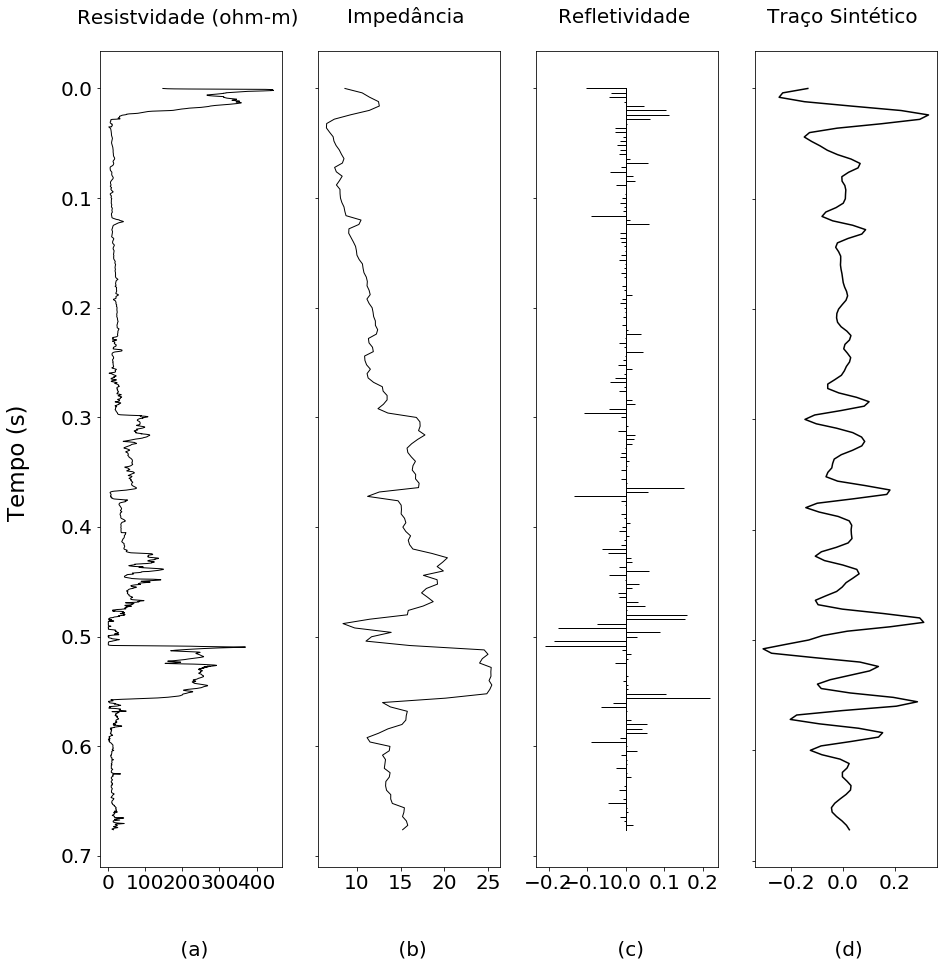

In [186]:
synth = cria_synth(resistividade, impedancia, tempo, N, fcorte, taxa_r, pol=False)

# Primeira Amarração



### Abaixo podemos ver a sísmica e traço mais próximo do poço que desejamos amarrar.

O traço sísmico de coordenada mais próxima do poço (traço 8608) é utilizado como traço central na amarração.  
**namostras:** quantidade de amostras em tempo no dado sísmico  
**t_central:** traço central, sobre o qual será posicionado o perfil sintético

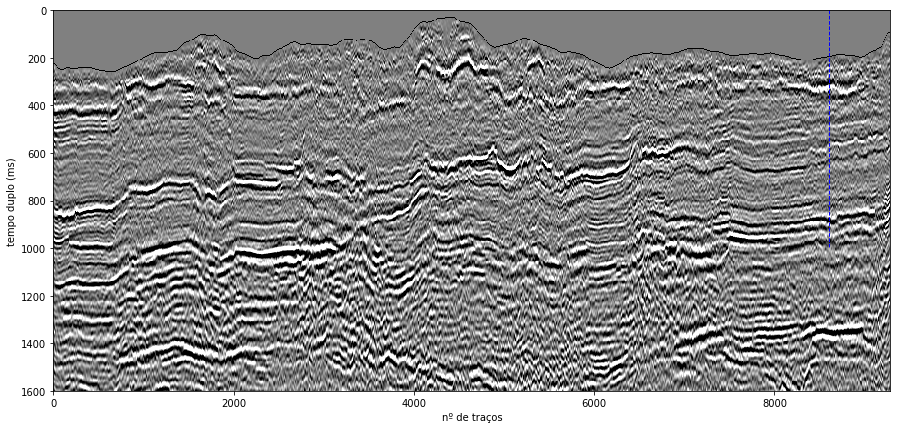

In [173]:
#endereço do arquivo .segy no seu computador - string
endereco = r'G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\0317-0112_Cimageo\0317-0112_PSTM.sgy'

namostras=400 #escolher aqui a quantidade de amostras da sísmica que deseja visualizar
t_central=8608 #traço mais próximo do poço
mtraces = carrega_segy(endereco, namostras, t_central)

### Amarrando o Poço

#### Slice do .segy com 300 traços próximos ao traço central

  
**t_laterais:** quantidade de traços desejados nas laterais do traço central

In [174]:
t_laterais=300
traces_slice=mtraces[:namostras,t_central-t_laterais:t_central+t_laterais+1]

#### Cálculo do Time Shift

+ Correção com relação ao datum final de processamento da sísmica. Os valores estão baseados no relatório da sísmica, que diz que o datum de processamento é 600m e a velocidade de substituição é 3000m/s. A elevação do poço foi retirada do pdf do Perfil Composto.  
**d_proc:** datum de processamento  
**elev:** elevação do poço  
**x1:** distância calculada em metros entre o datum de processamento e o topo do poço  
**v1:** velocida de substituição para a distância x1  

+ Correção com relação à falta de dados do poço:  
**x2:** distância em metros entre o início da perfilagem e o topo do poço  
**v2:** velocidade estimada de substituição para a distância x2  

In [175]:
d_proc=600.0
elev=260.0

x2=10.0
v2=2000.0
x1=d_proc-elev 
v1=3000.0

time_shift=2*((x2/v2)+(x1/v1)) #cálculo time shift

#### Plotando o slice do .segy com o sintético por cima

**traces_slice:** slice do segy  
**vmin, vmax:** ajeita a escala de cores  
**extent:** serve para ajustar a escala da imagem. Neste caso, a escala está sendo ajustada para coincidir com a escala de tempo, na vertical, e traços na horizontal. (300 traços para cada lado do sintético e o tempo variando de 0 a 2400ms)

+ No comando "pylab.plot" plotamos o sintético com um shift de 10 traços para a direita (10+synth) e com o time_shift calculado acima (multiplicado por 1000ms para conversão de segundos em milissegundos)
+ Para plotar as soleiras precisamos dar o mesmo time_shift para que elas ficassem posicionadas nos locais corretos com relação ao sintético


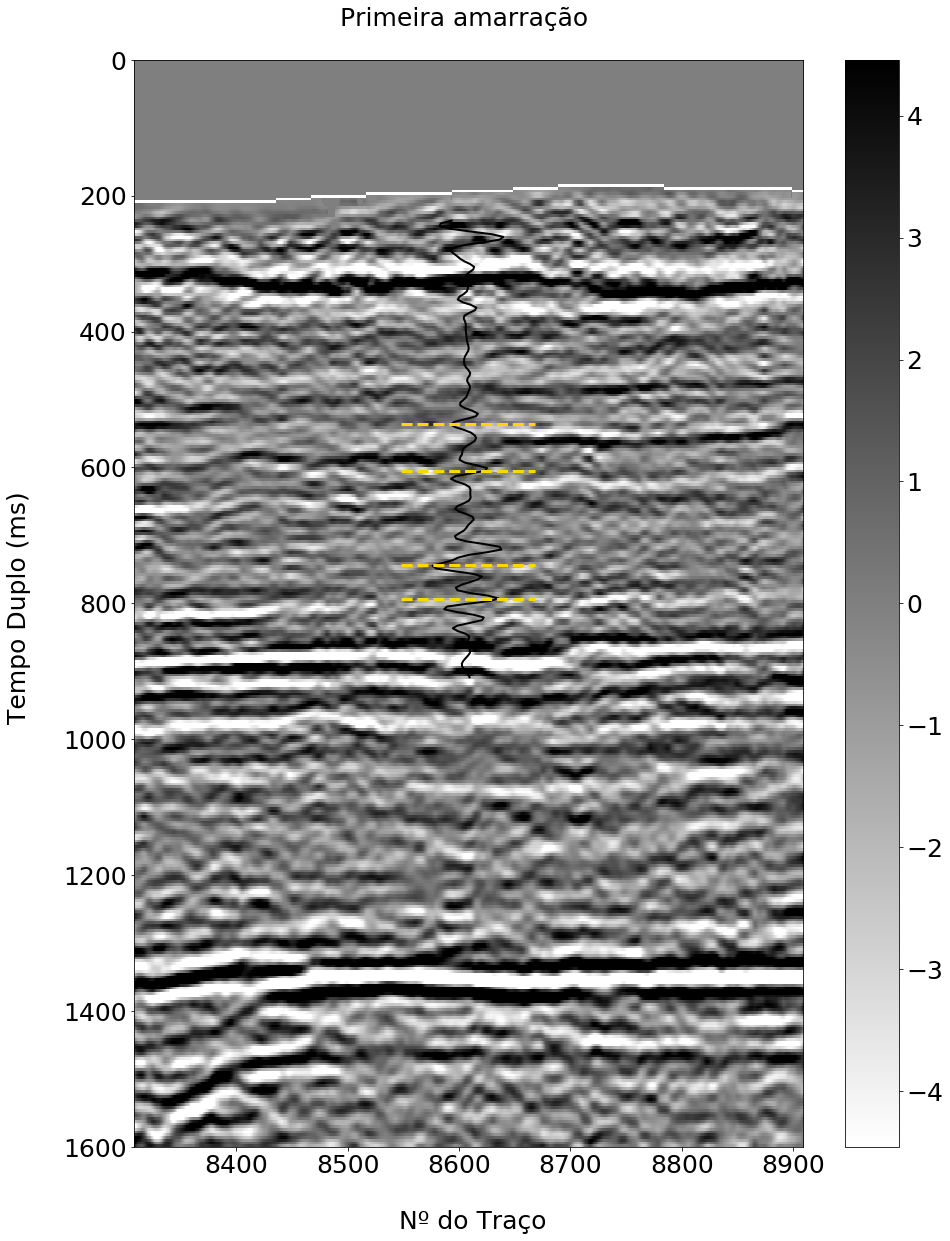

In [176]:
plt.figure(figsize=(15,20))

ax = plt.subplot(111)
plt.imshow(traces_slice, aspect='auto', cmap=pylab.cm.gray_r, origin='upper', vmin=-vmax, vmax=vmax, 
             extent=[t_central-t_laterais, t_central+t_laterais+1, namostras*4., 0.]) #imageamento do slice

plt.plot(t_central-1+synth*100, time_shift*1000+np.array(range(synth.size))*4, c='k', lw=2) #plot do sintético

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)

for i in range(len(soleiras)):
    plt.axhline(y = time_shift*1000+soleiras[i]*1000, xmin = 0.4, xmax = 0.6, lw=3,  c='gold', ls='--')
    #plot das soleiras em amarelo

plt.title('Primeira amarração \n', fontsize=25)
plt.xlabel('\n Nº do Traço', fontsize=25)
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.ylabel('Tempo Duplo (ms) \n', fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)

plt.savefig('primeira_amarração', dpi=600)

## Correção de Drift

In [178]:
#renomeamos as variáveis para evitar qualquer sobreposição de valores
twt_perfildt = tempo
md_perfildt = profundidade
vel_perfildt = velocidade*1000

#### Carregamento da TDR do poço próximo e cálculo do drift

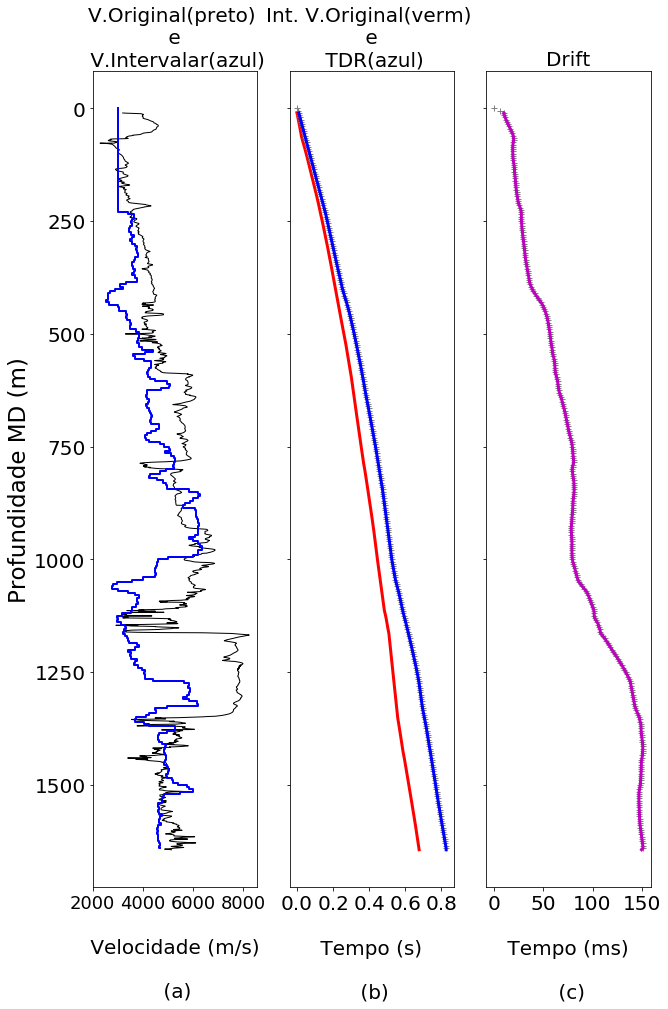

In [179]:
endereco_TDR = 'G:\Equipe\Raquel Macedo\VII SimBGF\Parnaiba - dados e codigos\\1-FL-1-PI\checkshot_1FL0001PI.csv'

(graph_twt_drift, md_vsp, twt_vsp, vel_vsp, twt_perfildt, md_perfildt, 
 vel_perfildt) = carrega_TDR_proximo(endereco_TDR, twt_perfildt, md_perfildt, vel_perfildt)

#### Cálculo da tendência do drift e aplicação desta tendência sobre a TDR do poço alvo

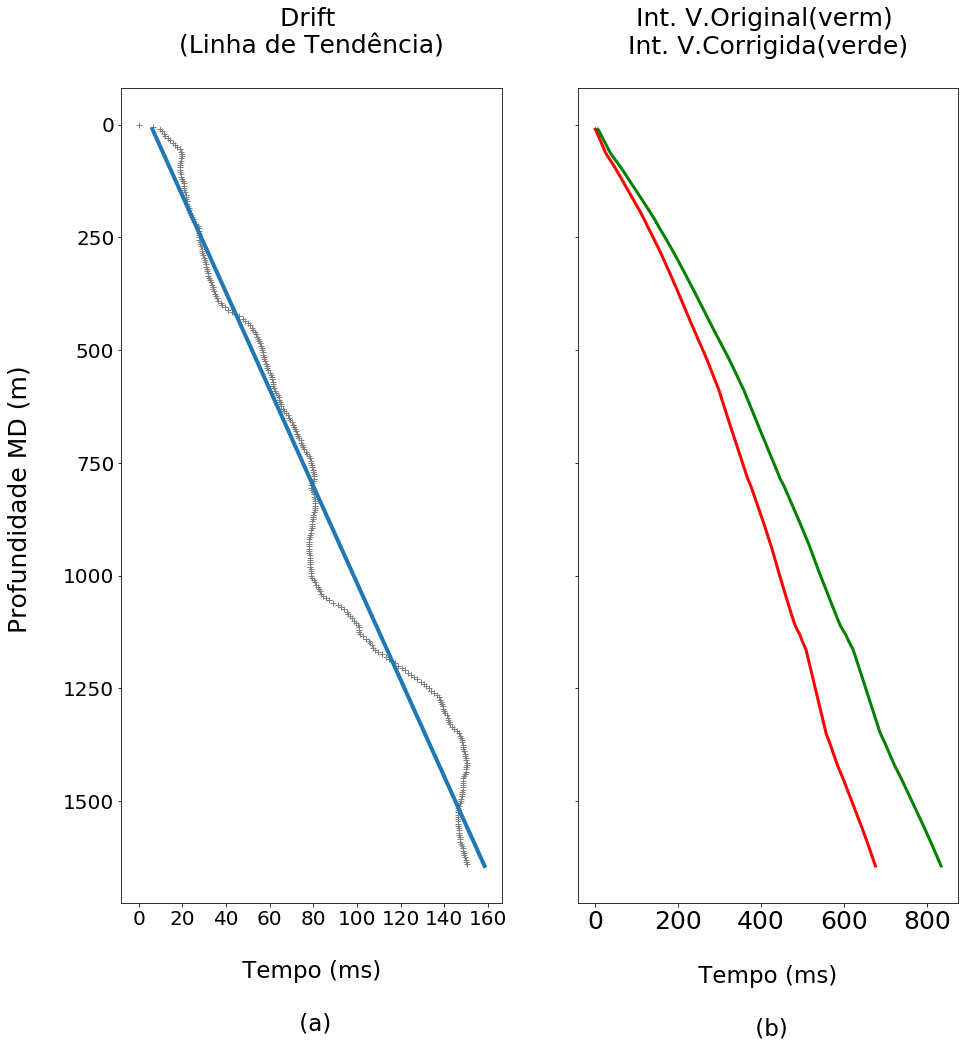

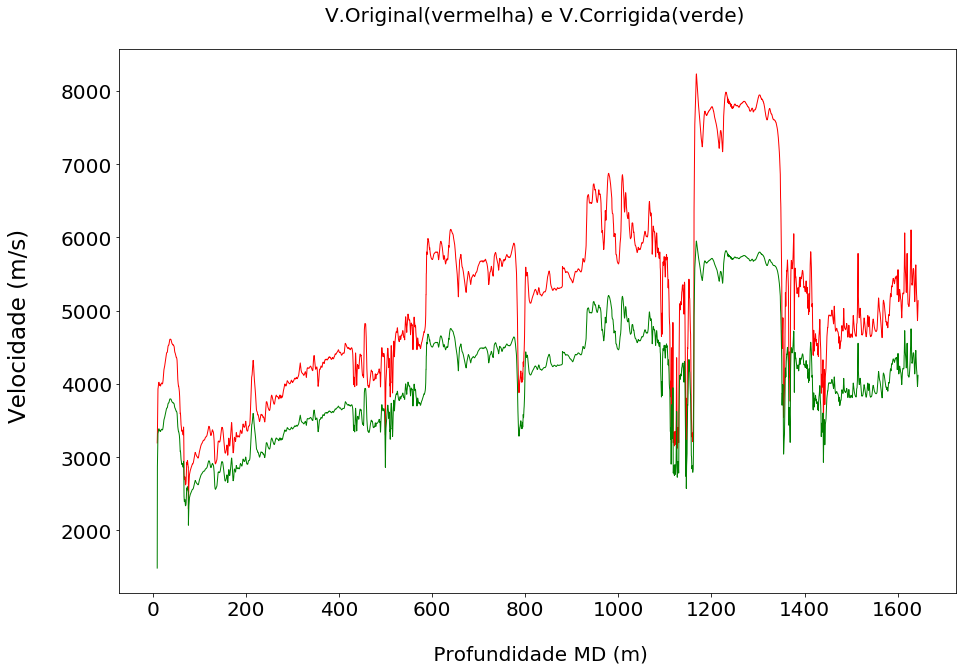

In [180]:
corrige_drift(graph_twt_drift, md_vsp, twt_vsp, vel_vsp, twt_perfildt, md_perfildt, vel_perfildt)

# Segunda Amarração

#### Carregando o sônico salvo em arquivo
Houve um problema que gerou um valor de velocidade muito baixo no perfil de velocidades corrigidas, e por isso descartamos os valores de velocidades inferiores a 2000m/s que não tem sentido físico para o nosso problema.

In [181]:
vel_corrigida = np.loadtxt('sonico_corrigido', delimiter=';')
twt_corrigido = np.loadtxt('twt_corrigido', delimiter=';')
vel_corrigida = vel_corrigida [ vel_corrigida > 2000 ] #descartando velocidades inferiores a 2000m/s

#### Criação do Traço Sintético corrigido

In [183]:
synth_corr = cria_synth(resistividade, impedancia, twt_corrigido, N, fcorte, taxa_r, pol=False, plot=False)

C:\Users\rmdias\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


#### Encontrando as posições corrigidas das soleiras no tempo

In [190]:
s1_t_corr = depth_time(t1, twt_corrigido, profundidade) #topo da primeira soleira
s1_b_corr = depth_time(b1, twt_corrigido, profundidade) #base da primeira soleira
s2_t_corr = depth_time(t2, twt_corrigido, profundidade) #topo da segunda soleira
s2_b_corr = depth_time(b2, twt_corrigido, profundidade) #base da segunda soleira

soleiras_corr=(s1_t_corr, s1_b_corr, s2_t_corr, s2_b_corr)

#### Plot segunda amarração

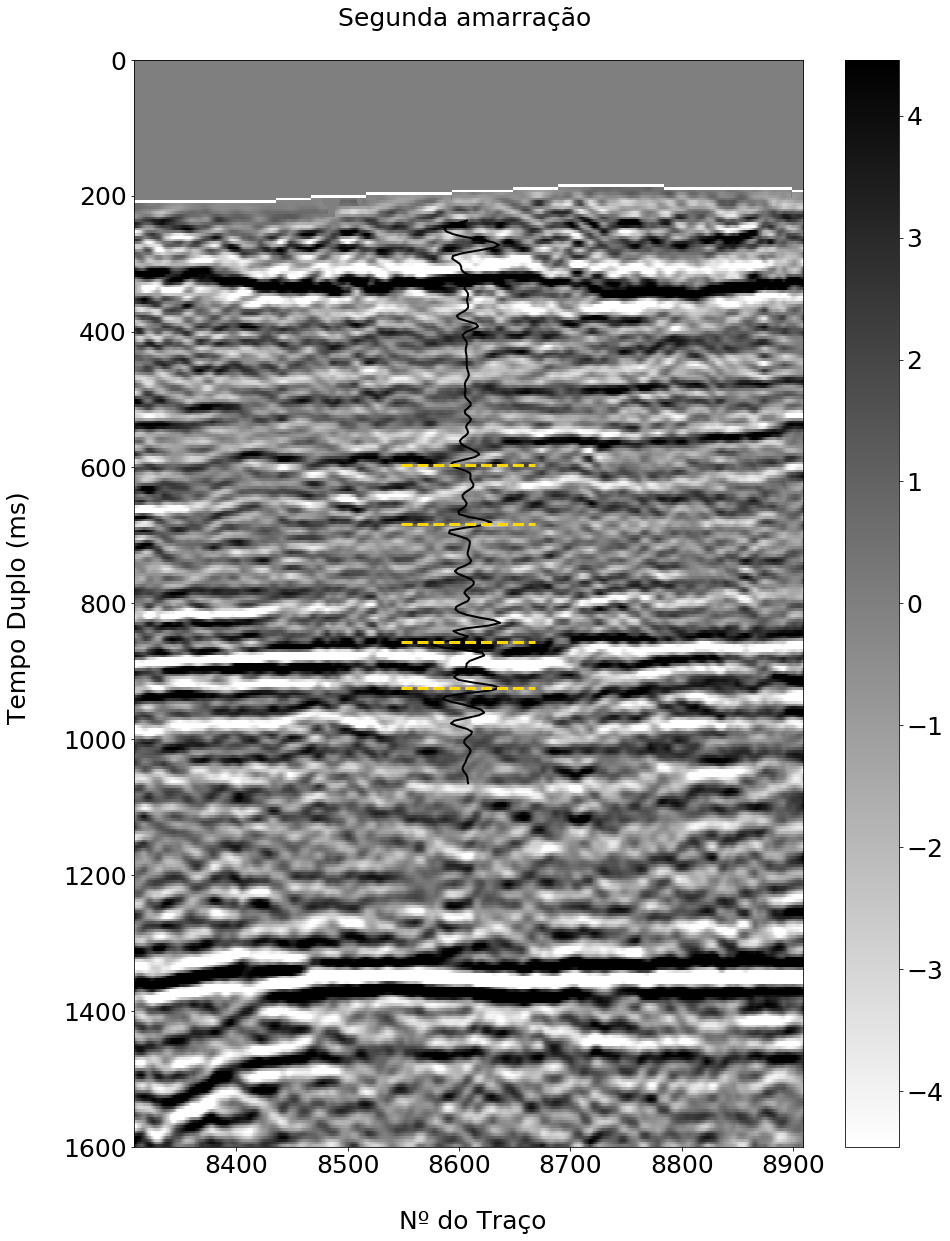

In [191]:
plt.figure(figsize=(15,20))

ax = plt.subplot(111)
plt.imshow(traces_slice, aspect='auto', cmap=pylab.cm.gray_r, origin='upper', vmin=-vmax, vmax=vmax, 
             extent=[t_central-t_laterais, t_central+t_laterais+1, namostras*4., 0.])
plt.plot(t_central-1+synth_corr*100, time_shift*1000+np.array(range(synth_corr.size))*4, c='k', lw=2)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)

for i in range(len(soleiras_corr)):
    plt.axhline(y = time_shift*1000+soleiras_corr[i]*1000, xmin = 0.4, xmax = 0.6, c='gold', lw=3, ls='--')

plt.title('Segunda amarração \n', fontsize=25)
plt.xlabel('\n Nº do Traço', fontsize=25)
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.ylabel('Tempo Duplo (ms) \n', fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)    

plt.savefig('segunda_amarração', dpi=600)

### Analisando as novas velocidades das soleiras

In [192]:
v_sol1_corr=(b1-t1)*2/(s1_b_corr-s1_t_corr)
v_sol2_corr=(b2-t2)*2/(s2_b_corr-s2_t_corr)
print('v. média soleira 1:', v_sol1_corr,'m/s',',', 'v. média soleira 2:', v_sol2_corr,'m/s')

v. média soleira 1: 4481.52771786 m/s , v. média soleira 2: 5586.94820893 m/s


#### Análise do atributo de envelope

In [198]:
envelope = np.abs(hilbert(mtraces, axis=0)) #cálculo do envelope

#cálculo dos percentis para ajuste da colorbar
vmax_h = np.percentile(envelope.ravel(), 99.0)
vmin_h = np.percentile(envelope.ravel(), 1.0)

#slice do envelope com 300 traços laterais
envelope_slice=envelope[:namostras,t_central-t_laterais:t_central+t_laterais+1]

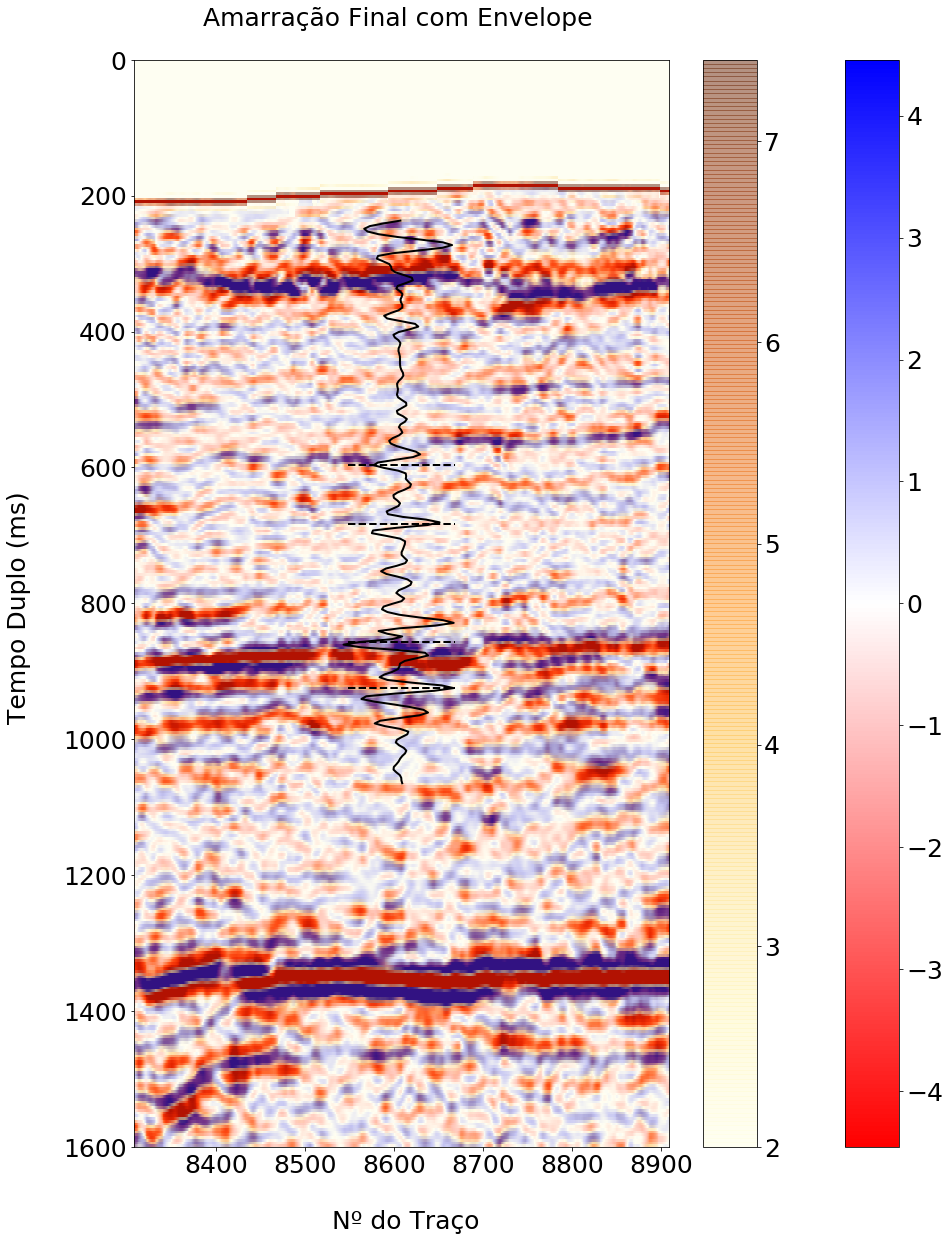

In [199]:
plt.figure(figsize=(15,20))

ax = plt.subplot(111)
plt.imshow(traces_slice, aspect='auto', cmap='bwr_r', origin='upper', vmin=-vmax, vmax=vmax, 
             extent=[t_central-t_laterais, t_central+t_laterais+1, namostras*4., 0.])

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)

plt.imshow(envelope_slice, aspect='auto', cmap='YlOrBr', origin='upper', vmin=2, vmax=vmax_h, 
             extent=[t_central-t_laterais, t_central+t_laterais+1, namostras*4., 0.], alpha=0.5)
plt.plot(t_central-1+synth_corr*200, time_shift*1000+np.array(range(synth_corr.size))*4, lw=2, c='k')

cbar2 = plt.colorbar()
cbar2.ax.tick_params(labelsize=25)

for i in range(len(soleiras_corr)):
    plt.axhline(y = time_shift*1000+soleiras_corr[i]*1000, xmin = 0.4, xmax = 0.6, c='k', lw=2, ls='--')

plt.title('Amarração Final com Envelope \n', fontsize=25)
plt.xlabel('\n Nº do Traço', fontsize=25)
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.ylabel('Tempo Duplo (ms) \n', fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)

plt.savefig('amarraçao_final_envelope.png', dpi=600)